In [5]:
#git clone https://github.com/ziatdinovmax/im2spec.git
%cd im2spec

/home/cloud/ipynb_files/im2spec


In [6]:
import gym
from gym import spaces
import numpy as np
#import pygame


import scipy
import gdown
import h5py
import matplotlib.pyplot as plt

import os
from copy import deepcopy as dc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from im2spec.models import im2spec, spec2im, conv_block, dilated_block
from im2spec.utils import create_training_set, predict, encode, decode
from im2spec.train_utils import trainer

import random
from collections import namedtuple, deque
from typing import List, Tuple
import math

import aecroscopy
from aecroscopy.acquisition.AEBE import AEBE   # include the Acquistion_v0.py in the same directory
from aecroscopy.acquisition.AECypher import AECypher

In [19]:
def feature_extractor(model, X):
    return(model.encoder(torch.tensor(X).reshape(X.shape[0], 1, image_patch, image_patch)))

In [20]:
def get_image_patch(image, pos, image_patch):
    return(image[pos[0]-int((image_patch-1)/2): pos[0] + int((image_patch+1)/2), pos[1]-int((image_patch-1)/2): pos[1] + int((image_patch+1)/2)])

In [21]:
def err_train(X, reward, criterion, optimizer, autoencoder):
    data = feature_extractor(autoencoder, np.array(X)).float().to(device = device)
       
    targets = torch.tensor(reward).float().to(device = device)

    scores = error_predictor(data)

    loss = criterion(scores, targets.reshape(targets.shape[0], 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [3]:
def coord(pos, image_size):
    return(np.array([[2*pos[0]/image_size - 1], [2*pos[1]/image_size - 1]]))

In [22]:
class im2im(nn.Module):
    def __init__(self,
                 feature_size: Tuple[int, int],
                 latent_dim: int = 10,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(im2im, self).__init__()
        self.n, self.m = feature_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=2, nb_layers=3,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.enc_fc = nn.Linear(self.e_filt * self.n * self.m, latent_dim)
        # Decoder params
        self.dec_fc = nn.Linear(latent_dim, self.d_filt * (self.n//4) * (self.n//4))
        self.dec_conv_1 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_2 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_atrous = dilated_block(
            ndim=2, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_3 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv2d(1, 1, 1)
    
    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the input image into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.m * self.n)
        return self.enc_fc(x)
    
    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 2D image from the embedded features
        """
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.n//4, self.n//4)
        x = self.dec_conv_1(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.dec_conv_2(x)
        x = F.interpolate(x, scale_factor=self.n/(2 * (self.n//4)), mode="nearest")
        x = self.dec_atrous(x)
        x = self.dec_conv_3(x)
        return self.dec_out(x)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)
    

In [8]:
class environment(gym.Env):
    def __init__(self, pola, image, spectra, model, start = [50, 50], image_patch = 5, image_size = 100):
        super(environment, self).__init__()
        self.num_not_measure = 0
        self.num_measure = 0
        self.image_size = image_size
        self.image_patch = image_patch
        self.radius = int((image_patch - 1)/2)+1
        self.image = image
        self.pola = pola
        self.spectra = spectra
        #self.color = 255/(image.max() - image.min()) * image - 255/(image.max() - image.min()) * image.min()
        self.num_rows = image_size
        self.num_columns = image_size
        self.all_X = []
        self.X = []
        self.y = []
        self.all_X.append(get_image_patch(self.image, start, self.image_patch))
        self.X.append((get_image_patch(self.image, start, self.image_patch)))
        
        vdc_vector, dset_imgs, dset_chns, dset_complex_spectra = newexp.do_beps_specific(file_name = "BEPS_point", coordinates=coord(pos, image_size))
        y_raw = (dset_imgs[0,0,1::2]*np.cos(dset_imgs[0,3,1::2]))[:64]
        self.y.append(2/(pola.max() - pola.min()) * y_raw - 2/(pola.max() - pola.min()) * pola.min() - 1)
        
        self.seen = np.zeros([100, 100])
        self.pos_X = [start]
        self.pos = start
        self.measured = np.zeros([image_size, image_size])
        self.display = np.zeros([image_size, image_size])
        self.measured[start[0], start[1]] = 1
        self.model = trainer(model, np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), num_epochs=1, savename="im2spec_lv{}".format(10)).run()
        pred_loop = predict(model, np.array(self.X[-1]).reshape([1, 1, self.image_patch, self.image_patch])).reshape(64)
        self.reward = [np.sum((pred_loop - self.y[-1])**2)]
        
        for i in range(self.radius):
                for j in range(self.radius):
                    self.seen[start[0]+i, start[1]+j] = 1
                    self.seen[start[0]-i, start[1]+j] = 1
                    self.seen[start[0]+i, start[1]-j] = 1
                    self.seen[start[0]-i, start[1]-j] = 1
        
        
        self.observation_space = spaces.Tuple((spaces.Discrete(self.num_rows), spaces.Discrete(self.num_columns)))
        
        #pygame.init()
        #self.cell_size = 8
        #self.screen = pygame.display.set_mode((self.num_columns * self.cell_size, self.num_rows * self.cell_size))
    
    def update_pos(self):
        self.pos[0] = random.randint(self.radius-1, self.image_size - self.radius)
        self.pos[1] = random.randint(self.radius-1, self.image_size - self.radius)
        while self.measured[self.pos[0], self.pos[1]] == 1:
            self.pos[0] = random.randint(self.radius-1, self.image_size - self.radius)
            self.pos[1] = random.randint(self.radius-1, self.image_size - self.radius)
            
        self.all_X.append(get_image_patch(self.image, self.pos, self.image_patch))
    
    def step(self, action, display, num_epochs = 100):
        
        
        if action == 0:
            self.num_not_measure += 1
            #self.reward.append(0)
        if action == 1:
            self.num_measure += 1
            ind = self.pos
            if self.measured[ind[0], ind[1]] == 0:
                self.measured[ind[0], ind[1]] = 1
                if display:
                    self.display[ind[0], ind[1]] = 1
                for i in range(self.radius):
                    for j in range(self.radius):
                        self.seen[ind[0]+i, ind[1]+j] = 1
                        self.seen[ind[0]-i, ind[1]+j] = 1
                        self.seen[ind[0]+i, ind[1]-j] = 1
                        self.seen[ind[0]-i, ind[1]-j] = 1
                self.X.append(get_image_patch(self.image, self.pos, self.image_patch))
                
                vdc_vector, dset_imgs, dset_chns, dset_complex_spectra = newexp.do_beps_specific(file_name = "BEPS_point", coordinates=coord(pos, image_size))
                y_raw = (dset_imgs[0,0,1::2]*np.cos(dset_imgs[0,3,1::2]))[:64]
                self.y.append(2/(self.pola.max() - self.pola.min()) * y_raw - 2/(self.pola.max() -self.pola.min()) * self.pola.min() - 1)
                
                self.pos_X.append([ind[0], ind[1]])
                pred_loop = predict(model, np.array(self.X[-1]).reshape([1, 1, self.image_patch, self.image_patch])).reshape(64)
            
                self.model = trainer(self.model, np.array(self.X[-num_epochs:]).reshape([len(self.X[-num_epochs:]), 1, self.image_patch, self.image_patch]), np.array(self.y[-num_epochs:]).reshape([len(self.y[-num_epochs:]), 1, 64]), np.array(self.X[-num_epochs:]).reshape([len(self.X[-num_epochs:]), 1, self.image_patch, self.image_patch]), np.array(self.y[-num_epochs:]).reshape([len(self.y[-num_epochs:]), 1, 64]), num_epochs=1, savename="im2spec_lv{}".format(10)).run()
                
                X_r = np.array(env.X).reshape([len(self.X), 1, self.image_patch, self.image_patch])
                y_p = predict(model, X_r)
                y_p = y_p.reshape([y_p.shape[0], y_p.shape[2]])
                
                self.reward = ((np.array(self.y) - y_p)**2).sum(axis = 1)/env.spectra.shape[2]

    
            
        
    
    def state(self):

        state = list(self.all_X[-1].reshape(self.image_patch**2))

        return(state, self.reward)
    
    #def render(self):

        #self.screen.fill((255, 255, 255)) 
        
        #for row in range(self.num_rows):
            #for col in range(self.num_columns):
                #cell_left = col * self.cell_size
                #cell_top = row * self.cell_size
                
                #pygame.draw.rect(self.screen, (0, 0, self.color[row, col]), (cell_left, cell_top, self.cell_size, self.cell_size))
                
                #if self.display[row, col] == 1:
                    
                    #pygame.draw.rect(self.screen, (255, 0, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
                
                #if [row, col] == self.pos:
                    
                    #pygame.draw.rect(self.screen, (0, 255, 0), (cell_left, cell_top, self.cell_size, self.cell_size))
        
                

        #pygame.display.update()

            
    def reset(self, model, start = [50, 50]):
        self.num_measure = 0
        self.pos_X = [[start[0], start[1]]]
        self.all_X = []
        self.X = []
        self.y = []
        self.all_X.append(get_image_patch(self.image, start, self.image_patch))
        self.X.append((get_image_patch(self.image, start, self.image_patch)))
        self.y.append(spectra[start[0], start[1]])
        self.seen = np.zeros([100, 100])
        self.pos = start
        self.measured = np.zeros([100, 100])
        self.measured[start[0], start[1]] = 1
        self.model = trainer(model, np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), num_epochs=1, savename="im2spec_lv{}".format(10)).run()
        for i in range(self.radius):
                for j in range(self.radius):
                    self.seen[start[0]+i, start[1]+j] = 1
                    self.seen[start[0]-i, start[1]+j] = 1
                    self.seen[start[0]+i, start[1]-j] = 1
                    self.seen[start[0]-i, start[1]-j] = 1
        
        
        self.observation_space = spaces.Tuple((spaces.Discrete(self.num_rows), spaces.Discrete(self.num_columns)))
        self.model = trainer(model, np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), np.array(self.X).reshape([len(self.X), 1, self.image_patch, self.image_patch]), np.array(self.y).reshape([len(self.y), 1, 64]), num_epochs=1, savename="im2spec_lv{}".format(10)).run()
        pred_loop = predict(model, np.array(self.X[-1]).reshape([1, 1, self.image_patch, self.image_patch])).reshape(64)
        self.reward = [np.sum((pred_loop - self.y[-1])**2)/self.y[-1].shape[0]]
        #pygame.init()
        #self.cell_size = 8
        #self.screen = pygame.display.set_mode((self.num_columns * self.cell_size, self.num_rows * self.cell_size))
    

In [28]:
class rewards_model(nn.Module):

    def __init__(self, n_observations):
        super(rewards_model, self).__init__()
        #self.dropout = nn.Dropout(0.5)
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 1)
        #self.layer3 = nn.Linear(128, 1)


    def forward(self, x):
        #x = self.dropout(x)
        x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))
        #return self.layer3(x)
        return self.layer2(x)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image_size = 100

In [ ]:
newexp1 = AECypher()
#newexp1.Set_MasterPanel(masterpanel_parameters = {"ScanSize": 2E-6, "ScanAngle": 90, "DriveAmplitude": 1.5})
newexp = AEBE(exe_path = "C:\STAFF Software\Yongtao_AE\BEPyAE 060523 01\\BEPyAE.exe")
newexp.init_BEPyAE(offline_development = False)

In [ ]:
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 360, "band_width_Hz_01": image_size,
                                       "amplitude_V_02": 2, "phase_variation_03": 1,
                                       "repeats_04": 4, "req_pulse_duration_s_05": 4,
                                       "auto_smooth_ring_06": 1}, 
                      do_create_be_waveform = True)

In [ ]:
dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"scan_pixel": 256, "scan_x_start": -1,
                                                                       "scan_y_start": -1,"scan_x_stop": 1,
                                                                 ""      "scan_y_stop":1}, file_name = "vpfmm")

pola = dset_pfm[:,:,0] * np.cos(dset_pfm[:,:,3])
image = 2/(pola.max() - pola.min()) * pola - 2/(pola.max() - pola.min()) * pola.min() - 1

In [ ]:
newexp.define_BEPS_parameters(beps_parms_dict = {"amplitude_V_00": 8, "step_per_cycle_03": 128, "num_cycles_04": 2, 
                                                 "measure_loops_07": 0, "transition_time_s_08": 1E-3})

In [30]:
start = [50, 50]
initialize = 30
image_patch = 5
image, spectra = norm_pola[:,:,0], norm_pola[:,:,::2][:,:,:64]

In [31]:
radius = int((image_patch - 1)/2)
pos_X = []
X = []
y = []
for i in range(radius, image_size - radius):
    for j in range(radius, image_size - radius):
        pos_X.append([i, j])
        ind = pos_X[-1]
        X.append( get_image_patch(image, ind, image_patch))
        y.append(spectra[ind[0], ind[1]])
X = np.array(X)
y = np.array(y)
X = X.reshape([X.shape[0], 1, image_patch, image_patch])
y = y.reshape([y.shape[0], 1, 64])

autoencoder = im2im((image_patch, image_patch), 10)
autoencoder = trainer(autoencoder, X[::10], X[::10], X, X, num_epochs=100, savename="im2spec_lv{}".format(10)).run()

Epoch: 1... Training loss: 0.00193... Test loss: 0.00173
Epoch: 2... Training loss: 0.00171... Test loss: 0.00158
Epoch: 3... Training loss: 0.0015... Test loss: 0.0014
Epoch: 4... Training loss: 0.0013... Test loss: 0.00118
Epoch: 5... Training loss: 0.00112... Test loss: 0.00101
Epoch: 6... Training loss: 0.00093... Test loss: 0.00085
Epoch: 7... Training loss: 0.00078... Test loss: 0.00068
Epoch: 8... Training loss: 0.00066... Test loss: 0.00063
Epoch: 9... Training loss: 0.00055... Test loss: 0.00057
Epoch: 10... Training loss: 0.00046... Test loss: 0.00042
Epoch: 11... Training loss: 0.00037... Test loss: 0.00039
Epoch: 12... Training loss: 0.00032... Test loss: 0.00031
Epoch: 13... Training loss: 0.00026... Test loss: 0.00023
Epoch: 14... Training loss: 0.00023... Test loss: 0.0002
Epoch: 15... Training loss: 0.00019... Test loss: 0.00015
Epoch: 16... Training loss: 0.00016... Test loss: 0.00015
Epoch: 17... Training loss: 0.00014... Test loss: 0.00013
Epoch: 18... Training loss:

In [32]:
loss_list = []

for k in range(50):

    model = im2spec((image_patch, image_patch), 64, 10)
    error_predictor = rewards_model(10).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(pola, image, spectra, model, start, image_patch, image_size)

    for i in range(initialize):
        env.update_pos()
        env.step(1, False)
        
    for j in range(10*initialize):
        err_train(env.X, env.reward, criterion, optimizer, autoencoder)

    count = 0
    while env.num_measure < 200:
        env.update_pos()
        
        r_set = np.array(error_predictor(feature_extractor(autoencoder, np.array(env.all_X[-10:]))).detach())
        r_set = r_set.reshape(r_set.shape[0])
        
        if error_predictor(feature_extractor(autoencoder, np.array([env.all_X[-1]]))).item() < (r_set.mean() + 2*r_set.std()*np.exp(-1*count /100)):
            action = 0
            count += 1
        else:
            count = 0
            action = 1
            for j in range(10):
                ind_initial = random.sample(list(range(0, initialize)), 5)
                X_initial = list(np.array(env.X)[ind_initial, :, :])
                reward_initial = list(env.reward[ind_initial])
                
                ind_middle = random.sample(list(range(min(initialize, len(env.X) - 5), len(env.X))), 5)
                X_middle = list(np.array(env.X)[ind_middle, :, :])
                reward_middle = list(env.reward[ind_middle])

                err_train(np.array(env.X[-10:] + X_initial + X_middle), list(env.reward[-10:]) + reward_initial + reward_middle, criterion, optimizer, autoencoder)

        env.step(action, True)

    y_pred = model(torch.tensor(X))
    
    err = np.zeros([100 - 2*radius, 100 - 2*radius])
    for i in range(len(pos_X)):
        err[pos_X[i][0]-radius, pos_X[i][1]-radius] = (((y_pred - torch.tensor(y))**2).sum(axis = 2)/y.shape[2]).reshape((100 - 2*radius)**2)[i]

    err_pred_tensor = error_predictor(feature_extractor(model, X)).reshape(X.shape[0])
    err_pred = np.zeros([100 - 2*radius, 100 - 2*radius])
    for i in range(len(pos_X)):
        err_pred[pos_X[i][0]-radius, pos_X[i][1]-radius] = err_pred_tensor[i]
    
    loss = err.sum()
    print(loss)
    
    loss_list.append(loss)
    
    

Epoch: 1... Training loss: 1.04106... Test loss: 0.18565
Epoch: 1... Training loss: 0.48533... Test loss: 0.07294
Epoch: 1... Training loss: 0.34235... Test loss: 0.05664
Epoch: 1... Training loss: 0.23398... Test loss: 0.0308
Epoch: 1... Training loss: 0.16398... Test loss: 0.02233
Epoch: 1... Training loss: 0.12011... Test loss: 0.03155
Epoch: 1... Training loss: 0.09039... Test loss: 0.01073
Epoch: 1... Training loss: 0.07274... Test loss: 0.02393
Epoch: 1... Training loss: 0.06073... Test loss: 0.02399
Epoch: 1... Training loss: 0.05487... Test loss: 0.00547
Epoch: 1... Training loss: 0.05036... Test loss: 0.02497
Epoch: 1... Training loss: 0.04548... Test loss: 0.00371
Epoch: 1... Training loss: 0.04186... Test loss: 0.01884
Epoch: 1... Training loss: 0.04038... Test loss: 0.00897
Epoch: 1... Training loss: 0.03359... Test loss: 0.01327
Epoch: 1... Training loss: 0.03238... Test loss: 0.00755
Epoch: 1... Training loss: 0.02901... Test loss: 0.01697
Epoch: 1... Training loss: 0.027

Epoch: 1... Training loss: 0.00314... Test loss: 0.00354
Epoch: 1... Training loss: 0.0031... Test loss: 0.00426
Epoch: 1... Training loss: 0.00306... Test loss: 0.0032
Epoch: 1... Training loss: 0.00293... Test loss: 0.00419
Epoch: 1... Training loss: 0.00285... Test loss: 0.0032
Epoch: 1... Training loss: 0.00279... Test loss: 0.00385
Epoch: 1... Training loss: 0.00269... Test loss: 0.00398
Epoch: 1... Training loss: 0.00263... Test loss: 0.00362
Epoch: 1... Training loss: 0.00259... Test loss: 0.00384
Epoch: 1... Training loss: 0.00244... Test loss: 0.00356
Epoch: 1... Training loss: 0.00241... Test loss: 0.00278
Epoch: 1... Training loss: 0.0023... Test loss: 0.00272
Epoch: 1... Training loss: 0.00223... Test loss: 0.00244
Epoch: 1... Training loss: 0.00217... Test loss: 0.00279
Epoch: 1... Training loss: 0.00207... Test loss: 0.00296
Epoch: 1... Training loss: 0.00199... Test loss: 0.00227
Epoch: 1... Training loss: 0.00189... Test loss: 0.00276
Epoch: 1... Training loss: 0.00195.

Epoch: 1... Training loss: 0.01077... Test loss: 0.00656
Epoch: 1... Training loss: 0.01058... Test loss: 0.00889
Epoch: 1... Training loss: 0.01012... Test loss: 0.00711
Epoch: 1... Training loss: 0.00977... Test loss: 0.00909
Epoch: 1... Training loss: 0.00929... Test loss: 0.00668
Epoch: 1... Training loss: 0.00902... Test loss: 0.00977
Epoch: 1... Training loss: 0.00878... Test loss: 0.00608
Epoch: 1... Training loss: 0.00864... Test loss: 0.0088
Epoch: 1... Training loss: 0.00831... Test loss: 0.00598
Epoch: 1... Training loss: 0.00816... Test loss: 0.00806
Epoch: 1... Training loss: 0.00777... Test loss: 0.00594
Epoch: 1... Training loss: 0.00766... Test loss: 0.00756
Epoch: 1... Training loss: 0.00731... Test loss: 0.00515
Epoch: 1... Training loss: 0.00715... Test loss: 0.00708
Epoch: 1... Training loss: 0.00687... Test loss: 0.00467
Epoch: 1... Training loss: 0.00668... Test loss: 0.00641
Epoch: 1... Training loss: 0.00651... Test loss: 0.00508
Epoch: 1... Training loss: 0.006

Epoch: 1... Training loss: 9e-05... Test loss: 0.00012
Epoch: 1... Training loss: 8e-05... Test loss: 0.0001
Epoch: 1... Training loss: 8e-05... Test loss: 0.0001
Epoch: 1... Training loss: 9e-05... Test loss: 0.0001
Epoch: 1... Training loss: 9e-05... Test loss: 8e-05
Epoch: 1... Training loss: 7e-05... Test loss: 0.00011
Epoch: 1... Training loss: 0.00012... Test loss: 7e-05
Epoch: 1... Training loss: 6e-05... Test loss: 8e-05
Epoch: 1... Training loss: 8e-05... Test loss: 8e-05
Epoch: 1... Training loss: 8e-05... Test loss: 8e-05
Epoch: 1... Training loss: 8e-05... Test loss: 8e-05
Epoch: 1... Training loss: 8e-05... Test loss: 6e-05
Epoch: 1... Training loss: 7e-05... Test loss: 7e-05
Epoch: 1... Training loss: 7e-05... Test loss: 6e-05
232.7404486181331
Epoch: 1... Training loss: 1.08916... Test loss: 0.46852
Epoch: 1... Training loss: 0.5077... Test loss: 0.1877
Epoch: 1... Training loss: 0.32706... Test loss: 0.12198
Epoch: 1... Training loss: 0.21552... Test loss: 0.11388
Epoch

Epoch: 1... Training loss: 0.00099... Test loss: 0.00117
Epoch: 1... Training loss: 0.00097... Test loss: 0.00137
Epoch: 1... Training loss: 0.00095... Test loss: 0.00103
Epoch: 1... Training loss: 0.00092... Test loss: 0.00123
Epoch: 1... Training loss: 0.0009... Test loss: 0.0009
Epoch: 1... Training loss: 0.00085... Test loss: 0.00105
Epoch: 1... Training loss: 0.00089... Test loss: 0.00076
Epoch: 1... Training loss: 0.00078... Test loss: 0.00082
Epoch: 1... Training loss: 0.00078... Test loss: 0.00065
Epoch: 1... Training loss: 0.00074... Test loss: 0.00076
Epoch: 1... Training loss: 0.00074... Test loss: 0.00065
Epoch: 1... Training loss: 0.00074... Test loss: 0.0006
Epoch: 1... Training loss: 0.00066... Test loss: 0.00058
Epoch: 1... Training loss: 0.00068... Test loss: 0.00076
Epoch: 1... Training loss: 0.00063... Test loss: 0.00047
Epoch: 1... Training loss: 0.0006... Test loss: 0.00079
Epoch: 1... Training loss: 0.00061... Test loss: 0.00056
Epoch: 1... Training loss: 0.00057.

Epoch: 1... Training loss: 0.00639... Test loss: 0.00743
Epoch: 1... Training loss: 0.00607... Test loss: 0.00869
Epoch: 1... Training loss: 0.00597... Test loss: 0.00747
Epoch: 1... Training loss: 0.0063... Test loss: 0.00716
Epoch: 1... Training loss: 0.00516... Test loss: 0.00816
Epoch: 1... Training loss: 0.00506... Test loss: 0.00698
Epoch: 1... Training loss: 0.00524... Test loss: 0.00673
Epoch: 1... Training loss: 0.00481... Test loss: 0.00588
Epoch: 1... Training loss: 0.005... Test loss: 0.00644
Epoch: 1... Training loss: 0.00464... Test loss: 0.0049
Epoch: 1... Training loss: 0.00436... Test loss: 0.00641
Epoch: 1... Training loss: 0.00428... Test loss: 0.00505
Epoch: 1... Training loss: 0.0041... Test loss: 0.00602
Epoch: 1... Training loss: 0.00387... Test loss: 0.00443
Epoch: 1... Training loss: 0.00373... Test loss: 0.00575
Epoch: 1... Training loss: 0.0035... Test loss: 0.00431
Epoch: 1... Training loss: 0.0036... Test loss: 0.00398
Epoch: 1... Training loss: 0.00343... 

Epoch: 1... Training loss: 0.023... Test loss: 0.01225
Epoch: 1... Training loss: 0.02159... Test loss: 0.00588
Epoch: 1... Training loss: 0.02046... Test loss: 0.00868
Epoch: 1... Training loss: 0.01996... Test loss: 0.00591
Epoch: 1... Training loss: 0.01875... Test loss: 0.00818
Epoch: 1... Training loss: 0.01855... Test loss: 0.00834
Epoch: 1... Training loss: 0.01753... Test loss: 0.00564
Epoch: 1... Training loss: 0.01693... Test loss: 0.01172
Epoch: 1... Training loss: 0.0157... Test loss: 0.00579
Epoch: 1... Training loss: 0.01511... Test loss: 0.01392
Epoch: 1... Training loss: 0.01493... Test loss: 0.00486
Epoch: 1... Training loss: 0.01402... Test loss: 0.01179
Epoch: 1... Training loss: 0.0141... Test loss: 0.00825
Epoch: 1... Training loss: 0.01324... Test loss: 0.00801
Epoch: 1... Training loss: 0.01287... Test loss: 0.00744
Epoch: 1... Training loss: 0.01239... Test loss: 0.0088
Epoch: 1... Training loss: 0.01196... Test loss: 0.00789
Epoch: 1... Training loss: 0.01153..

Epoch: 1... Training loss: 0.00032... Test loss: 0.00023
Epoch: 1... Training loss: 0.00028... Test loss: 0.00028
Epoch: 1... Training loss: 0.00025... Test loss: 0.0002
Epoch: 1... Training loss: 0.00022... Test loss: 0.00036
Epoch: 1... Training loss: 0.00024... Test loss: 0.0002
Epoch: 1... Training loss: 0.00021... Test loss: 0.00029
Epoch: 1... Training loss: 0.00021... Test loss: 0.0002
Epoch: 1... Training loss: 0.00023... Test loss: 0.00021
Epoch: 1... Training loss: 0.00022... Test loss: 0.0002
Epoch: 1... Training loss: 0.0002... Test loss: 0.00028
Epoch: 1... Training loss: 0.00023... Test loss: 0.00019
Epoch: 1... Training loss: 0.0002... Test loss: 0.00023
Epoch: 1... Training loss: 0.0002... Test loss: 0.0002
Epoch: 1... Training loss: 0.00019... Test loss: 0.00022
Epoch: 1... Training loss: 0.00019... Test loss: 0.00017
Epoch: 1... Training loss: 0.00017... Test loss: 0.0002
Epoch: 1... Training loss: 0.00017... Test loss: 0.00015
Epoch: 1... Training loss: 0.00017... Te

Epoch: 1... Training loss: 0.00241... Test loss: 0.00271
Epoch: 1... Training loss: 0.00218... Test loss: 0.00286
Epoch: 1... Training loss: 0.00219... Test loss: 0.00239
Epoch: 1... Training loss: 0.00211... Test loss: 0.00271
Epoch: 1... Training loss: 0.00217... Test loss: 0.00224
Epoch: 1... Training loss: 0.00195... Test loss: 0.00257
Epoch: 1... Training loss: 0.00194... Test loss: 0.00204
Epoch: 1... Training loss: 0.00191... Test loss: 0.00255
Epoch: 1... Training loss: 0.00179... Test loss: 0.0023
Epoch: 1... Training loss: 0.00175... Test loss: 0.00244
Epoch: 1... Training loss: 0.00164... Test loss: 0.00192
Epoch: 1... Training loss: 0.00162... Test loss: 0.00219
Epoch: 1... Training loss: 0.00158... Test loss: 0.00185
Epoch: 1... Training loss: 0.00152... Test loss: 0.00156
Epoch: 1... Training loss: 0.00143... Test loss: 0.00174
Epoch: 1... Training loss: 0.00149... Test loss: 0.00187
Epoch: 1... Training loss: 0.0013... Test loss: 0.00164
Epoch: 1... Training loss: 0.0013

Epoch: 1... Training loss: 0.00758... Test loss: 0.00804
Epoch: 1... Training loss: 0.00732... Test loss: 0.00832
Epoch: 1... Training loss: 0.0071... Test loss: 0.00739
Epoch: 1... Training loss: 0.00684... Test loss: 0.00786
Epoch: 1... Training loss: 0.00658... Test loss: 0.00784
Epoch: 1... Training loss: 0.0064... Test loss: 0.00684
Epoch: 1... Training loss: 0.00629... Test loss: 0.00728
Epoch: 1... Training loss: 0.00598... Test loss: 0.00588
Epoch: 1... Training loss: 0.00594... Test loss: 0.00739
Epoch: 1... Training loss: 0.0058... Test loss: 0.00631
Epoch: 1... Training loss: 0.00563... Test loss: 0.00761
Epoch: 1... Training loss: 0.00541... Test loss: 0.00563
Epoch: 1... Training loss: 0.00529... Test loss: 0.00706
Epoch: 1... Training loss: 0.00828... Test loss: 0.0077
Epoch: 1... Training loss: 0.00837... Test loss: 0.01483
Epoch: 1... Training loss: 0.00983... Test loss: 0.01302
Epoch: 1... Training loss: 0.01105... Test loss: 0.0108
Epoch: 1... Training loss: 0.0083...

Epoch: 1... Training loss: 0.0001... Test loss: 0.00012
Epoch: 1... Training loss: 0.00012... Test loss: 7e-05
Epoch: 1... Training loss: 9e-05... Test loss: 0.00011
Epoch: 1... Training loss: 0.0001... Test loss: 9e-05
Epoch: 1... Training loss: 9e-05... Test loss: 0.0001
235.537767225469
Epoch: 1... Training loss: 1.2775... Test loss: 0.61669
Epoch: 1... Training loss: 0.58653... Test loss: 0.24572
Epoch: 1... Training loss: 0.31444... Test loss: 0.1306
Epoch: 1... Training loss: 0.20016... Test loss: 0.07945
Epoch: 1... Training loss: 0.15583... Test loss: 0.06449
Epoch: 1... Training loss: 0.11395... Test loss: 0.04329
Epoch: 1... Training loss: 0.0977... Test loss: 0.05884
Epoch: 1... Training loss: 0.08821... Test loss: 0.02922
Epoch: 1... Training loss: 0.07264... Test loss: 0.0363
Epoch: 1... Training loss: 0.06247... Test loss: 0.02205
Epoch: 1... Training loss: 0.05614... Test loss: 0.03584
Epoch: 1... Training loss: 0.05711... Test loss: 0.02103
Epoch: 1... Training loss: 0.

Epoch: 1... Training loss: 0.00064... Test loss: 0.0009
Epoch: 1... Training loss: 0.00061... Test loss: 0.00058
Epoch: 1... Training loss: 0.00057... Test loss: 0.00074
Epoch: 1... Training loss: 0.00056... Test loss: 0.00055
Epoch: 1... Training loss: 0.00057... Test loss: 0.00062
Epoch: 1... Training loss: 0.0005... Test loss: 0.00052
Epoch: 1... Training loss: 0.00047... Test loss: 0.00056
Epoch: 1... Training loss: 0.0005... Test loss: 0.00063
Epoch: 1... Training loss: 0.00046... Test loss: 0.00043
Epoch: 1... Training loss: 0.00042... Test loss: 0.00052
Epoch: 1... Training loss: 0.0004... Test loss: 0.00041
Epoch: 1... Training loss: 0.00038... Test loss: 0.00049
Epoch: 1... Training loss: 0.00042... Test loss: 0.00037
Epoch: 1... Training loss: 0.00034... Test loss: 0.00044
Epoch: 1... Training loss: 0.00033... Test loss: 0.00028
Epoch: 1... Training loss: 0.00028... Test loss: 0.00042
Epoch: 1... Training loss: 0.00029... Test loss: 0.00025
Epoch: 1... Training loss: 0.00027.

Epoch: 1... Training loss: 0.00441... Test loss: 0.0069
Epoch: 1... Training loss: 0.005... Test loss: 0.00598
Epoch: 1... Training loss: 0.00421... Test loss: 0.00687
Epoch: 1... Training loss: 0.00437... Test loss: 0.00578
Epoch: 1... Training loss: 0.0043... Test loss: 0.00467
Epoch: 1... Training loss: 0.00435... Test loss: 0.00485
Epoch: 1... Training loss: 0.00394... Test loss: 0.00476
Epoch: 1... Training loss: 0.00364... Test loss: 0.0047
Epoch: 1... Training loss: 0.00365... Test loss: 0.00366
Epoch: 1... Training loss: 0.00349... Test loss: 0.0049
Epoch: 1... Training loss: 0.00332... Test loss: 0.00337
Epoch: 1... Training loss: 0.00325... Test loss: 0.00398
Epoch: 1... Training loss: 0.00304... Test loss: 0.0035
Epoch: 1... Training loss: 0.00314... Test loss: 0.00443
Epoch: 1... Training loss: 0.00307... Test loss: 0.00359
Epoch: 1... Training loss: 0.00283... Test loss: 0.00346
Epoch: 1... Training loss: 0.00283... Test loss: 0.00307
Epoch: 1... Training loss: 0.00264... 

Epoch: 1... Training loss: 0.01738... Test loss: 0.00357
Epoch: 1... Training loss: 0.01651... Test loss: 0.01109
Epoch: 1... Training loss: 0.01601... Test loss: 0.00698
Epoch: 1... Training loss: 0.01584... Test loss: 0.0047
Epoch: 1... Training loss: 0.01515... Test loss: 0.01312
Epoch: 1... Training loss: 0.01452... Test loss: 0.00441
Epoch: 1... Training loss: 0.01428... Test loss: 0.01315
Epoch: 1... Training loss: 0.01342... Test loss: 0.00627
Epoch: 1... Training loss: 0.01304... Test loss: 0.01277
Epoch: 1... Training loss: 0.01253... Test loss: 0.00666
Epoch: 1... Training loss: 0.01237... Test loss: 0.01069
Epoch: 1... Training loss: 0.01177... Test loss: 0.00651
Epoch: 1... Training loss: 0.01142... Test loss: 0.01122
Epoch: 1... Training loss: 0.01066... Test loss: 0.00567
Epoch: 1... Training loss: 0.01034... Test loss: 0.0128
Epoch: 1... Training loss: 0.01... Test loss: 0.00657
Epoch: 1... Training loss: 0.00952... Test loss: 0.00991
Epoch: 1... Training loss: 0.00894..

Epoch: 1... Training loss: 0.00017... Test loss: 0.00012
Epoch: 1... Training loss: 0.00018... Test loss: 0.00022
Epoch: 1... Training loss: 0.00016... Test loss: 0.00013
Epoch: 1... Training loss: 0.00015... Test loss: 0.00018
Epoch: 1... Training loss: 0.00019... Test loss: 0.00012
Epoch: 1... Training loss: 0.00014... Test loss: 0.00013
Epoch: 1... Training loss: 0.00014... Test loss: 0.00012
Epoch: 1... Training loss: 0.00021... Test loss: 0.00011
Epoch: 1... Training loss: 0.00013... Test loss: 0.00012
Epoch: 1... Training loss: 0.00013... Test loss: 0.00015
Epoch: 1... Training loss: 0.00011... Test loss: 0.00014
Epoch: 1... Training loss: 0.00011... Test loss: 0.00013
Epoch: 1... Training loss: 0.00012... Test loss: 0.00011
Epoch: 1... Training loss: 0.00014... Test loss: 0.00011
Epoch: 1... Training loss: 0.0001... Test loss: 0.0001
Epoch: 1... Training loss: 0.00011... Test loss: 0.00012
Epoch: 1... Training loss: 0.00016... Test loss: 9e-05
Epoch: 1... Training loss: 0.00012.

Epoch: 1... Training loss: 0.00154... Test loss: 0.00167
Epoch: 1... Training loss: 0.0014... Test loss: 0.00177
Epoch: 1... Training loss: 0.00152... Test loss: 0.00131
Epoch: 1... Training loss: 0.00129... Test loss: 0.00183
Epoch: 1... Training loss: 0.0014... Test loss: 0.00173
Epoch: 1... Training loss: 0.00131... Test loss: 0.00175
Epoch: 1... Training loss: 0.00121... Test loss: 0.00134
Epoch: 1... Training loss: 0.00116... Test loss: 0.00166
Epoch: 1... Training loss: 0.00116... Test loss: 0.00144
Epoch: 1... Training loss: 0.00108... Test loss: 0.00113
Epoch: 1... Training loss: 0.00104... Test loss: 0.00137
Epoch: 1... Training loss: 0.00094... Test loss: 0.00126
Epoch: 1... Training loss: 0.00101... Test loss: 0.0011
Epoch: 1... Training loss: 0.00091... Test loss: 0.00097
Epoch: 1... Training loss: 0.00086... Test loss: 0.00094
Epoch: 1... Training loss: 0.00076... Test loss: 0.00087
Epoch: 1... Training loss: 0.00081... Test loss: 0.00099
Epoch: 1... Training loss: 0.00076

Epoch: 1... Training loss: 0.00528... Test loss: 0.00591
Epoch: 1... Training loss: 0.00515... Test loss: 0.0051
Epoch: 1... Training loss: 0.00496... Test loss: 0.00547
Epoch: 1... Training loss: 0.00481... Test loss: 0.00515
Epoch: 1... Training loss: 0.0123... Test loss: 0.01004
Epoch: 1... Training loss: 0.01092... Test loss: 0.01084
Epoch: 1... Training loss: 0.00931... Test loss: 0.0102
Epoch: 1... Training loss: 0.00842... Test loss: 0.00837
Epoch: 1... Training loss: 0.00765... Test loss: 0.01107
Epoch: 1... Training loss: 0.00925... Test loss: 0.00913
Epoch: 1... Training loss: 0.00803... Test loss: 0.01097
Epoch: 1... Training loss: 0.00772... Test loss: 0.01365
Epoch: 1... Training loss: 0.00668... Test loss: 0.00992
Epoch: 1... Training loss: 0.00681... Test loss: 0.01347
Epoch: 1... Training loss: 0.00766... Test loss: 0.01148
Epoch: 1... Training loss: 0.00648... Test loss: 0.00896
Epoch: 1... Training loss: 0.0068... Test loss: 0.00841
Epoch: 1... Training loss: 0.00625.

Epoch: 1... Training loss: 0.09119... Test loss: 0.05501
Epoch: 1... Training loss: 0.07837... Test loss: 0.05399
Epoch: 1... Training loss: 0.07116... Test loss: 0.0166
Epoch: 1... Training loss: 0.06518... Test loss: 0.04368
Epoch: 1... Training loss: 0.05254... Test loss: 0.02532
Epoch: 1... Training loss: 0.04883... Test loss: 0.03711
Epoch: 1... Training loss: 0.042... Test loss: 0.0268
Epoch: 1... Training loss: 0.0367... Test loss: 0.03506
Epoch: 1... Training loss: 0.03349... Test loss: 0.02138
Epoch: 1... Training loss: 0.03257... Test loss: 0.02889
Epoch: 1... Training loss: 0.03088... Test loss: 0.01536
Epoch: 1... Training loss: 0.02847... Test loss: 0.02774
Epoch: 1... Training loss: 0.02739... Test loss: 0.00985
Epoch: 1... Training loss: 0.02553... Test loss: 0.02762
Epoch: 1... Training loss: 0.02466... Test loss: 0.00905
Epoch: 1... Training loss: 0.02345... Test loss: 0.01638
Epoch: 1... Training loss: 0.02252... Test loss: 0.01236
Epoch: 1... Training loss: 0.02039..

Epoch: 1... Training loss: 0.00043... Test loss: 0.00032
Epoch: 1... Training loss: 0.0004... Test loss: 0.00042
Epoch: 1... Training loss: 0.0004... Test loss: 0.00031
Epoch: 1... Training loss: 0.00039... Test loss: 0.00039
Epoch: 1... Training loss: 0.00038... Test loss: 0.00034
Epoch: 1... Training loss: 0.00041... Test loss: 0.00033
Epoch: 1... Training loss: 0.00036... Test loss: 0.00026
Epoch: 1... Training loss: 0.00033... Test loss: 0.00034
Epoch: 1... Training loss: 0.00029... Test loss: 0.00031
Epoch: 1... Training loss: 0.00032... Test loss: 0.00031
Epoch: 1... Training loss: 0.0003... Test loss: 0.00023
Epoch: 1... Training loss: 0.00027... Test loss: 0.00038
Epoch: 1... Training loss: 0.00034... Test loss: 0.00021
Epoch: 1... Training loss: 0.0003... Test loss: 0.00034
Epoch: 1... Training loss: 0.00028... Test loss: 0.00024
Epoch: 1... Training loss: 0.00022... Test loss: 0.00029
Epoch: 1... Training loss: 0.00024... Test loss: 0.00018
Epoch: 1... Training loss: 0.00022.

Epoch: 1... Training loss: 0.00311... Test loss: 0.00417
Epoch: 1... Training loss: 0.00321... Test loss: 0.00327
Epoch: 1... Training loss: 0.00305... Test loss: 0.00428
Epoch: 1... Training loss: 0.00293... Test loss: 0.00302
Epoch: 1... Training loss: 0.00295... Test loss: 0.00445
Epoch: 1... Training loss: 0.0027... Test loss: 0.00291
Epoch: 1... Training loss: 0.00265... Test loss: 0.0039
Epoch: 1... Training loss: 0.00253... Test loss: 0.00287
Epoch: 1... Training loss: 0.00247... Test loss: 0.00338
Epoch: 1... Training loss: 0.00233... Test loss: 0.00271
Epoch: 1... Training loss: 0.00231... Test loss: 0.00291
Epoch: 1... Training loss: 0.00216... Test loss: 0.00283
Epoch: 1... Training loss: 0.00214... Test loss: 0.00219
Epoch: 1... Training loss: 0.00202... Test loss: 0.00214
Epoch: 1... Training loss: 0.00213... Test loss: 0.00226
Epoch: 1... Training loss: 0.00191... Test loss: 0.00236
Epoch: 1... Training loss: 0.00185... Test loss: 0.00198
Epoch: 1... Training loss: 0.0018

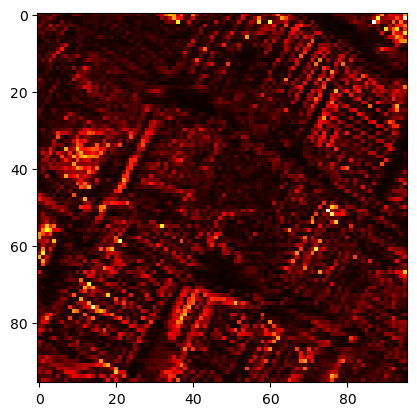

In [34]:
plt.imshow(err, cmap='hot', interpolation='nearest')
plt.show()

In [35]:
err.max()

0.24475690722465515

In [42]:
rand_loss_list = []

for k in range(50):

    model = im2spec((image_patch, image_patch), 64, 10)
    
    env = environment(image, spectra, model, start, image_patch)



    for i in range(initialize):
        env.update_pos()
        env.render()
        env.step(1, False)

    while env.num_measure < 200:
        env.update_pos()
        env.render()
        action = 1
        env.step(action, True)
        
    
    y_pred = model(torch.tensor(X))
    
    err = np.zeros([100 - 2*radius, 100 - 2*radius])
    
    for i in range(len(pos_X)):
        err[pos_X[i][0]-radius, pos_X[i][1]-radius] = (((y_pred - torch.tensor(y))**2).sum(axis = 2)/y.shape[2]).reshape((100 - 2*radius)**2)[i]
    
    loss = err.sum()
    print(loss)
    
    rand_loss_list.append(loss)

Epoch: 1... Training loss: 1.24475... Test loss: 0.56937
Epoch: 1... Training loss: 0.6063... Test loss: 0.23719
Epoch: 1... Training loss: 0.34113... Test loss: 0.14495
Epoch: 1... Training loss: 0.22925... Test loss: 0.09614
Epoch: 1... Training loss: 0.16437... Test loss: 0.08131
Epoch: 1... Training loss: 0.13068... Test loss: 0.03963
Epoch: 1... Training loss: 0.1096... Test loss: 0.04332
Epoch: 1... Training loss: 0.09254... Test loss: 0.06471
Epoch: 1... Training loss: 0.08161... Test loss: 0.02278
Epoch: 1... Training loss: 0.07106... Test loss: 0.03718
Epoch: 1... Training loss: 0.06353... Test loss: 0.03105
Epoch: 1... Training loss: 0.05745... Test loss: 0.04818
Epoch: 1... Training loss: 0.0516... Test loss: 0.01551
Epoch: 1... Training loss: 0.04569... Test loss: 0.03497
Epoch: 1... Training loss: 0.04173... Test loss: 0.02558
Epoch: 1... Training loss: 0.03814... Test loss: 0.01139
Epoch: 1... Training loss: 0.03679... Test loss: 0.04196
Epoch: 1... Training loss: 0.03388

Epoch: 1... Training loss: 0.00048... Test loss: 0.00046
Epoch: 1... Training loss: 0.00044... Test loss: 0.0005
Epoch: 1... Training loss: 0.00048... Test loss: 0.00048
Epoch: 1... Training loss: 0.00043... Test loss: 0.00046
Epoch: 1... Training loss: 0.00044... Test loss: 0.00042
Epoch: 1... Training loss: 0.00041... Test loss: 0.00042
Epoch: 1... Training loss: 0.00037... Test loss: 0.00035
Epoch: 1... Training loss: 0.00037... Test loss: 0.00039
Epoch: 1... Training loss: 0.00035... Test loss: 0.00033
Epoch: 1... Training loss: 0.00034... Test loss: 0.00034
Epoch: 1... Training loss: 0.00037... Test loss: 0.00035
Epoch: 1... Training loss: 0.00035... Test loss: 0.00031
Epoch: 1... Training loss: 0.00032... Test loss: 0.00031
Epoch: 1... Training loss: 0.0003... Test loss: 0.00028
Epoch: 1... Training loss: 0.00032... Test loss: 0.0003
Epoch: 1... Training loss: 0.00027... Test loss: 0.00028
Epoch: 1... Training loss: 0.00027... Test loss: 0.00028
Epoch: 1... Training loss: 0.00025

Epoch: 1... Training loss: 0.00236... Test loss: 0.00315
Epoch: 1... Training loss: 0.00231... Test loss: 0.00255
Epoch: 1... Training loss: 0.00224... Test loss: 0.00254
Epoch: 1... Training loss: 0.00219... Test loss: 0.00224
Epoch: 1... Training loss: 0.00222... Test loss: 0.00236
Epoch: 1... Training loss: 0.0021... Test loss: 0.00217
Epoch: 1... Training loss: 0.00206... Test loss: 0.00221
Epoch: 1... Training loss: 0.002... Test loss: 0.0019
Epoch: 1... Training loss: 0.00194... Test loss: 0.00255
Epoch: 1... Training loss: 0.00205... Test loss: 0.00196
Epoch: 1... Training loss: 0.00192... Test loss: 0.00216
Epoch: 1... Training loss: 0.0019... Test loss: 0.00202
Epoch: 1... Training loss: 0.00192... Test loss: 0.00211
Epoch: 1... Training loss: 0.00175... Test loss: 0.00187
Epoch: 1... Training loss: 0.00179... Test loss: 0.00211
Epoch: 1... Training loss: 0.00181... Test loss: 0.00166
Epoch: 1... Training loss: 0.00166... Test loss: 0.00199
Epoch: 1... Training loss: 0.00157..

Epoch: 1... Training loss: 0.0055... Test loss: 0.00559
Epoch: 1... Training loss: 0.00894... Test loss: 0.00951
Epoch: 1... Training loss: 0.01433... Test loss: 0.00953
Epoch: 1... Training loss: 0.01065... Test loss: 0.01063
Epoch: 1... Training loss: 0.01038... Test loss: 0.00871
Epoch: 1... Training loss: 0.01449... Test loss: 0.00805
Epoch: 1... Training loss: 0.00918... Test loss: 0.01147
Epoch: 1... Training loss: 0.01153... Test loss: 0.01028
Epoch: 1... Training loss: 0.00909... Test loss: 0.01173
Epoch: 1... Training loss: 0.01016... Test loss: 0.01143
Epoch: 1... Training loss: 0.009... Test loss: 0.01207
Epoch: 1... Training loss: 0.00783... Test loss: 0.01044
Epoch: 1... Training loss: 0.00727... Test loss: 0.01245
Epoch: 1... Training loss: 0.00793... Test loss: 0.00986
Epoch: 1... Training loss: 0.00716... Test loss: 0.01076
Epoch: 1... Training loss: 0.00765... Test loss: 0.00845
Epoch: 1... Training loss: 0.00738... Test loss: 0.0084
Epoch: 1... Training loss: 0.00756.

Epoch: 1... Training loss: 0.09355... Test loss: 0.04563
Epoch: 1... Training loss: 0.07093... Test loss: 0.02428
Epoch: 1... Training loss: 0.06019... Test loss: 0.04869
Epoch: 1... Training loss: 0.0516... Test loss: 0.02514
Epoch: 1... Training loss: 0.04526... Test loss: 0.03007
Epoch: 1... Training loss: 0.04076... Test loss: 0.02744
Epoch: 1... Training loss: 0.03864... Test loss: 0.02971
Epoch: 1... Training loss: 0.03568... Test loss: 0.0152
Epoch: 1... Training loss: 0.03318... Test loss: 0.02477
Epoch: 1... Training loss: 0.03186... Test loss: 0.00732
Epoch: 1... Training loss: 0.02756... Test loss: 0.01875
Epoch: 1... Training loss: 0.02651... Test loss: 0.00904
Epoch: 1... Training loss: 0.02554... Test loss: 0.01136
Epoch: 1... Training loss: 0.02461... Test loss: 0.01451
Epoch: 1... Training loss: 0.02283... Test loss: 0.00537
Epoch: 1... Training loss: 0.02231... Test loss: 0.01684
Epoch: 1... Training loss: 0.02089... Test loss: 0.01186
Epoch: 1... Training loss: 0.0193

Epoch: 1... Training loss: 0.00122... Test loss: 0.00108
Epoch: 1... Training loss: 0.00108... Test loss: 0.00126
Epoch: 1... Training loss: 0.00107... Test loss: 0.00111
Epoch: 1... Training loss: 0.00098... Test loss: 0.00119
Epoch: 1... Training loss: 0.00099... Test loss: 0.00094
Epoch: 1... Training loss: 0.0009... Test loss: 0.00101
Epoch: 1... Training loss: 0.00093... Test loss: 0.0009
Epoch: 1... Training loss: 0.00091... Test loss: 0.00097
Epoch: 1... Training loss: 0.0009... Test loss: 0.00075
Epoch: 1... Training loss: 0.00085... Test loss: 0.00107
Epoch: 1... Training loss: 0.00095... Test loss: 0.00096
Epoch: 1... Training loss: 0.0008... Test loss: 0.00104
Epoch: 1... Training loss: 0.00079... Test loss: 0.00089
Epoch: 1... Training loss: 0.00073... Test loss: 0.0009
Epoch: 1... Training loss: 0.00072... Test loss: 0.00089
Epoch: 1... Training loss: 0.0007... Test loss: 0.0007
Epoch: 1... Training loss: 0.00071... Test loss: 0.00073
Epoch: 1... Training loss: 0.00063... 

Epoch: 1... Training loss: 0.0043... Test loss: 0.00428
Epoch: 1... Training loss: 0.00415... Test loss: 0.00502
Epoch: 1... Training loss: 0.00391... Test loss: 0.00411
Epoch: 1... Training loss: 0.00387... Test loss: 0.00406
Epoch: 1... Training loss: 0.00383... Test loss: 0.00418
Epoch: 1... Training loss: 0.00378... Test loss: 0.00371
Epoch: 1... Training loss: 0.0037... Test loss: 0.00369
Epoch: 1... Training loss: 0.00358... Test loss: 0.00336
Epoch: 1... Training loss: 0.0036... Test loss: 0.00369
Epoch: 1... Training loss: 0.00362... Test loss: 0.00364
Epoch: 1... Training loss: 0.00353... Test loss: 0.00346
Epoch: 1... Training loss: 0.0035... Test loss: 0.00295
Epoch: 1... Training loss: 0.00346... Test loss: 0.00362
Epoch: 1... Training loss: 0.00332... Test loss: 0.00286
Epoch: 1... Training loss: 0.00335... Test loss: 0.00323
Epoch: 1... Training loss: 0.00331... Test loss: 0.00278
Epoch: 1... Training loss: 0.00314... Test loss: 0.00301
Epoch: 1... Training loss: 0.00311.

Epoch: 1... Training loss: 0.01214... Test loss: 0.0081
Epoch: 1... Training loss: 0.01165... Test loss: 0.00971
Epoch: 1... Training loss: 0.01162... Test loss: 0.00705
Epoch: 1... Training loss: 0.01109... Test loss: 0.01046
Epoch: 1... Training loss: 0.01107... Test loss: 0.00723
Epoch: 1... Training loss: 0.01041... Test loss: 0.01001
Epoch: 1... Training loss: 0.01009... Test loss: 0.00674
Epoch: 1... Training loss: 0.0097... Test loss: 0.00921
Epoch: 1... Training loss: 0.00954... Test loss: 0.00656
Epoch: 1... Training loss: 0.00917... Test loss: 0.00883
Epoch: 1... Training loss: 0.00891... Test loss: 0.00707
Epoch: 1... Training loss: 0.00854... Test loss: 0.00778
Epoch: 1... Training loss: 0.0084... Test loss: 0.00585
Epoch: 1... Training loss: 0.00793... Test loss: 0.00665
Epoch: 1... Training loss: 0.00778... Test loss: 0.00641
Epoch: 1... Training loss: 0.00758... Test loss: 0.00634
Epoch: 1... Training loss: 0.00745... Test loss: 0.0063
Epoch: 1... Training loss: 0.00714.

Epoch: 1... Training loss: 0.00043... Test loss: 0.00051
Epoch: 1... Training loss: 0.00043... Test loss: 0.0004
Epoch: 1... Training loss: 0.00042... Test loss: 0.0005
Epoch: 1... Training loss: 0.00036... Test loss: 0.00038
Epoch: 1... Training loss: 0.00036... Test loss: 0.00043
Epoch: 1... Training loss: 0.00038... Test loss: 0.00038
Epoch: 1... Training loss: 0.0003... Test loss: 0.0004
Epoch: 1... Training loss: 0.00032... Test loss: 0.00033
Epoch: 1... Training loss: 0.0003... Test loss: 0.00032
Epoch: 1... Training loss: 0.0003... Test loss: 0.00028
Epoch: 1... Training loss: 0.00026... Test loss: 0.00031
Epoch: 1... Training loss: 0.00028... Test loss: 0.00026
Epoch: 1... Training loss: 0.00024... Test loss: 0.00028
Epoch: 1... Training loss: 0.00023... Test loss: 0.00024
Epoch: 1... Training loss: 0.00024... Test loss: 0.00022
Epoch: 1... Training loss: 0.00021... Test loss: 0.00022
Epoch: 1... Training loss: 0.0002... Test loss: 0.00021
305.489882113412
Epoch: 1... Training 

Epoch: 1... Training loss: 0.00182... Test loss: 0.00207
Epoch: 1... Training loss: 0.00174... Test loss: 0.00184
Epoch: 1... Training loss: 0.00169... Test loss: 0.00204
Epoch: 1... Training loss: 0.00166... Test loss: 0.00186
Epoch: 1... Training loss: 0.00151... Test loss: 0.00193
Epoch: 1... Training loss: 0.00154... Test loss: 0.00199
Epoch: 1... Training loss: 0.0014... Test loss: 0.00195
Epoch: 1... Training loss: 0.00138... Test loss: 0.00141
Epoch: 1... Training loss: 0.00138... Test loss: 0.00159
Epoch: 1... Training loss: 0.00129... Test loss: 0.00145
Epoch: 1... Training loss: 0.00132... Test loss: 0.00139
Epoch: 1... Training loss: 0.00124... Test loss: 0.00151
Epoch: 1... Training loss: 0.00124... Test loss: 0.0012
Epoch: 1... Training loss: 0.0012... Test loss: 0.00146
Epoch: 1... Training loss: 0.00113... Test loss: 0.00118
Epoch: 1... Training loss: 0.00107... Test loss: 0.00112
Epoch: 1... Training loss: 0.00109... Test loss: 0.00139
Epoch: 1... Training loss: 0.00102

Epoch: 1... Training loss: 0.00986... Test loss: 0.00975
Epoch: 1... Training loss: 0.00907... Test loss: 0.00801
Epoch: 1... Training loss: 0.00947... Test loss: 0.01036
Epoch: 1... Training loss: 0.00861... Test loss: 0.00802
Epoch: 1... Training loss: 0.00837... Test loss: 0.01087
Epoch: 1... Training loss: 0.00836... Test loss: 0.00899
Epoch: 1... Training loss: 0.00767... Test loss: 0.00975
Epoch: 1... Training loss: 0.00758... Test loss: 0.00823
Epoch: 1... Training loss: 0.00728... Test loss: 0.00999
Epoch: 1... Training loss: 0.00678... Test loss: 0.00847
Epoch: 1... Training loss: 0.00645... Test loss: 0.00897
Epoch: 1... Training loss: 0.00664... Test loss: 0.00777
Epoch: 1... Training loss: 0.00647... Test loss: 0.00734
Epoch: 1... Training loss: 0.00643... Test loss: 0.00646
Epoch: 1... Training loss: 0.0062... Test loss: 0.00686
Epoch: 1... Training loss: 0.00571... Test loss: 0.00676
Epoch: 1... Training loss: 0.00572... Test loss: 0.00661
Epoch: 1... Training loss: 0.005

Epoch: 1... Training loss: 0.02789... Test loss: 0.00878
Epoch: 1... Training loss: 0.02574... Test loss: 0.00775
Epoch: 1... Training loss: 0.02484... Test loss: 0.00844
Epoch: 1... Training loss: 0.02372... Test loss: 0.00792
Epoch: 1... Training loss: 0.0229... Test loss: 0.00811
Epoch: 1... Training loss: 0.02194... Test loss: 0.00425
Epoch: 1... Training loss: 0.02108... Test loss: 0.01284
Epoch: 1... Training loss: 0.02013... Test loss: 0.00484
Epoch: 1... Training loss: 0.01908... Test loss: 0.0116
Epoch: 1... Training loss: 0.0184... Test loss: 0.00443
Epoch: 1... Training loss: 0.0179... Test loss: 0.01133
Epoch: 1... Training loss: 0.01709... Test loss: 0.00445
Epoch: 1... Training loss: 0.01675... Test loss: 0.00979
Epoch: 1... Training loss: 0.01591... Test loss: 0.00483
Epoch: 1... Training loss: 0.01536... Test loss: 0.00878
Epoch: 1... Training loss: 0.01476... Test loss: 0.00641
Epoch: 1... Training loss: 0.0143... Test loss: 0.01027
Epoch: 1... Training loss: 0.01367..

Epoch: 1... Training loss: 0.00092... Test loss: 0.001
Epoch: 1... Training loss: 0.00096... Test loss: 0.00094
Epoch: 1... Training loss: 0.00088... Test loss: 0.001
Epoch: 1... Training loss: 0.00089... Test loss: 0.00104
Epoch: 1... Training loss: 0.00077... Test loss: 0.00091
Epoch: 1... Training loss: 0.00074... Test loss: 0.00101
Epoch: 1... Training loss: 0.00073... Test loss: 0.0008
Epoch: 1... Training loss: 0.00066... Test loss: 0.00078
Epoch: 1... Training loss: 0.00065... Test loss: 0.00073
Epoch: 1... Training loss: 0.00062... Test loss: 0.00075
Epoch: 1... Training loss: 0.00063... Test loss: 0.00063
Epoch: 1... Training loss: 0.00059... Test loss: 0.00071
Epoch: 1... Training loss: 0.00053... Test loss: 0.00049
Epoch: 1... Training loss: 0.0006... Test loss: 0.00054
Epoch: 1... Training loss: 0.0005... Test loss: 0.0005
Epoch: 1... Training loss: 0.00051... Test loss: 0.00055
Epoch: 1... Training loss: 0.0005... Test loss: 0.00053
Epoch: 1... Training loss: 0.00051... Te

Epoch: 1... Training loss: 0.00359... Test loss: 0.004
Epoch: 1... Training loss: 0.00363... Test loss: 0.00337
Epoch: 1... Training loss: 0.00342... Test loss: 0.00427
Epoch: 1... Training loss: 0.00342... Test loss: 0.00353
Epoch: 1... Training loss: 0.00338... Test loss: 0.0042
Epoch: 1... Training loss: 0.00321... Test loss: 0.00326
Epoch: 1... Training loss: 0.00328... Test loss: 0.00419
Epoch: 1... Training loss: 0.00327... Test loss: 0.00335
Epoch: 1... Training loss: 0.00315... Test loss: 0.00362
Epoch: 1... Training loss: 0.00301... Test loss: 0.00304
Epoch: 1... Training loss: 0.00295... Test loss: 0.00348
Epoch: 1... Training loss: 0.00309... Test loss: 0.00313
Epoch: 1... Training loss: 0.00286... Test loss: 0.00329
Epoch: 1... Training loss: 0.0028... Test loss: 0.00312
Epoch: 1... Training loss: 0.00279... Test loss: 0.00303
Epoch: 1... Training loss: 0.0027... Test loss: 0.00285
Epoch: 1... Training loss: 0.00259... Test loss: 0.00306
Epoch: 1... Training loss: 0.00257..

Epoch: 1... Training loss: 0.00816... Test loss: 0.00555
Epoch: 1... Training loss: 0.00797... Test loss: 0.00799
Epoch: 1... Training loss: 0.00776... Test loss: 0.00535
Epoch: 1... Training loss: 0.00762... Test loss: 0.00742
Epoch: 1... Training loss: 0.00743... Test loss: 0.006
Epoch: 1... Training loss: 0.00717... Test loss: 0.00638
Epoch: 1... Training loss: 0.00698... Test loss: 0.00578
Epoch: 1... Training loss: 0.00665... Test loss: 0.00598
Epoch: 1... Training loss: 0.00646... Test loss: 0.00623
Epoch: 1... Training loss: 0.00627... Test loss: 0.00589
Epoch: 1... Training loss: 0.0062... Test loss: 0.0056
Epoch: 1... Training loss: 0.00595... Test loss: 0.00619
Epoch: 1... Training loss: 0.00587... Test loss: 0.00571
Epoch: 1... Training loss: 0.0057... Test loss: 0.00582
Epoch: 1... Training loss: 0.00562... Test loss: 0.0056
Epoch: 1... Training loss: 0.00544... Test loss: 0.00509
Epoch: 1... Training loss: 0.01565... Test loss: 0.01229
Epoch: 1... Training loss: 0.01238...

Epoch: 1... Training loss: 0.00036... Test loss: 0.00035
Epoch: 1... Training loss: 0.00036... Test loss: 0.00034
Epoch: 1... Training loss: 0.00031... Test loss: 0.00037
Epoch: 1... Training loss: 0.00033... Test loss: 0.0003
Epoch: 1... Training loss: 0.00028... Test loss: 0.00041
Epoch: 1... Training loss: 0.00026... Test loss: 0.00025
Epoch: 1... Training loss: 0.00023... Test loss: 0.00021
Epoch: 1... Training loss: 0.00022... Test loss: 0.00017
238.53286083083367
Epoch: 1... Training loss: 0.8778... Test loss: 0.28201
Epoch: 1... Training loss: 0.44851... Test loss: 0.1234
Epoch: 1... Training loss: 0.27799... Test loss: 0.09106
Epoch: 1... Training loss: 0.18377... Test loss: 0.06161
Epoch: 1... Training loss: 0.14717... Test loss: 0.04291
Epoch: 1... Training loss: 0.1212... Test loss: 0.03674
Epoch: 1... Training loss: 0.10302... Test loss: 0.03684
Epoch: 1... Training loss: 0.08388... Test loss: 0.02674
Epoch: 1... Training loss: 0.07957... Test loss: 0.02216
Epoch: 1... Trai

Epoch: 1... Training loss: 0.00161... Test loss: 0.00205
Epoch: 1... Training loss: 0.00157... Test loss: 0.00146
Epoch: 1... Training loss: 0.00158... Test loss: 0.00184
Epoch: 1... Training loss: 0.00156... Test loss: 0.00166
Epoch: 1... Training loss: 0.00145... Test loss: 0.00218
Epoch: 1... Training loss: 0.00142... Test loss: 0.00144
Epoch: 1... Training loss: 0.00137... Test loss: 0.00181
Epoch: 1... Training loss: 0.00129... Test loss: 0.00147
Epoch: 1... Training loss: 0.00128... Test loss: 0.00145
Epoch: 1... Training loss: 0.00125... Test loss: 0.00128
Epoch: 1... Training loss: 0.00117... Test loss: 0.00125
Epoch: 1... Training loss: 0.0011... Test loss: 0.00117
Epoch: 1... Training loss: 0.00116... Test loss: 0.0011
Epoch: 1... Training loss: 0.00109... Test loss: 0.00119
Epoch: 1... Training loss: 0.00113... Test loss: 0.00119
Epoch: 1... Training loss: 0.00098... Test loss: 0.00121
Epoch: 1... Training loss: 0.00103... Test loss: 0.00109
Epoch: 1... Training loss: 0.0009

Epoch: 1... Training loss: 0.007... Test loss: 0.00697
Epoch: 1... Training loss: 0.00676... Test loss: 0.00642
Epoch: 1... Training loss: 0.00641... Test loss: 0.00652
Epoch: 1... Training loss: 0.00637... Test loss: 0.00616
Epoch: 1... Training loss: 0.00609... Test loss: 0.00672
Epoch: 1... Training loss: 0.00617... Test loss: 0.00673
Epoch: 1... Training loss: 0.00573... Test loss: 0.00759
Epoch: 1... Training loss: 0.00587... Test loss: 0.00526
Epoch: 1... Training loss: 0.00529... Test loss: 0.00901
Epoch: 1... Training loss: 0.00532... Test loss: 0.00552
Epoch: 1... Training loss: 0.00523... Test loss: 0.00741
Epoch: 1... Training loss: 0.00493... Test loss: 0.00513
Epoch: 1... Training loss: 0.00496... Test loss: 0.00742
Epoch: 1... Training loss: 0.00498... Test loss: 0.00479
Epoch: 1... Training loss: 0.00443... Test loss: 0.00632
Epoch: 1... Training loss: 0.00454... Test loss: 0.00419
Epoch: 1... Training loss: 0.00472... Test loss: 0.00556
Epoch: 1... Training loss: 0.0044

Epoch: 1... Training loss: 0.02276... Test loss: 0.00904
Epoch: 1... Training loss: 0.02135... Test loss: 0.01911
Epoch: 1... Training loss: 0.02011... Test loss: 0.00883
Epoch: 1... Training loss: 0.01933... Test loss: 0.01966
Epoch: 1... Training loss: 0.01823... Test loss: 0.00972
Epoch: 1... Training loss: 0.01764... Test loss: 0.01572
Epoch: 1... Training loss: 0.01663... Test loss: 0.01454
Epoch: 1... Training loss: 0.01625... Test loss: 0.01289
Epoch: 1... Training loss: 0.01549... Test loss: 0.01511
Epoch: 1... Training loss: 0.0148... Test loss: 0.01119
Epoch: 1... Training loss: 0.01411... Test loss: 0.01313
Epoch: 1... Training loss: 0.01386... Test loss: 0.01052
Epoch: 1... Training loss: 0.01314... Test loss: 0.01223
Epoch: 1... Training loss: 0.01294... Test loss: 0.01203
Epoch: 1... Training loss: 0.01248... Test loss: 0.00821
Epoch: 1... Training loss: 0.01203... Test loss: 0.01266
Epoch: 1... Training loss: 0.01164... Test loss: 0.00724
Epoch: 1... Training loss: 0.011

Epoch: 1... Training loss: 0.0007... Test loss: 0.00069
Epoch: 1... Training loss: 0.00064... Test loss: 0.00059
Epoch: 1... Training loss: 0.00066... Test loss: 0.00062
Epoch: 1... Training loss: 0.0006... Test loss: 0.00056
Epoch: 1... Training loss: 0.00056... Test loss: 0.00065
Epoch: 1... Training loss: 0.00057... Test loss: 0.0006
Epoch: 1... Training loss: 0.0006... Test loss: 0.00067
Epoch: 1... Training loss: 0.00052... Test loss: 0.00053
Epoch: 1... Training loss: 0.00057... Test loss: 0.00053
Epoch: 1... Training loss: 0.0005... Test loss: 0.00046
Epoch: 1... Training loss: 0.00045... Test loss: 0.0005
Epoch: 1... Training loss: 0.00046... Test loss: 0.00042
Epoch: 1... Training loss: 0.0004... Test loss: 0.00047
Epoch: 1... Training loss: 0.00038... Test loss: 0.00046
Epoch: 1... Training loss: 0.00036... Test loss: 0.0004
Epoch: 1... Training loss: 0.00034... Test loss: 0.00039
Epoch: 1... Training loss: 0.00034... Test loss: 0.00033
Epoch: 1... Training loss: 0.00038... T

Epoch: 1... Training loss: 0.00284... Test loss: 0.00274
Epoch: 1... Training loss: 0.00272... Test loss: 0.00291
Epoch: 1... Training loss: 0.00267... Test loss: 0.00302
Epoch: 1... Training loss: 0.00269... Test loss: 0.00234
Epoch: 1... Training loss: 0.00268... Test loss: 0.00307
Epoch: 1... Training loss: 0.0025... Test loss: 0.00258
Epoch: 1... Training loss: 0.00255... Test loss: 0.00256
Epoch: 1... Training loss: 0.00241... Test loss: 0.00277
Epoch: 1... Training loss: 0.00244... Test loss: 0.00243
Epoch: 1... Training loss: 0.00237... Test loss: 0.00258
Epoch: 1... Training loss: 0.00244... Test loss: 0.00228
Epoch: 1... Training loss: 0.00229... Test loss: 0.00254
Epoch: 1... Training loss: 0.00219... Test loss: 0.00217
Epoch: 1... Training loss: 0.00234... Test loss: 0.00217
Epoch: 1... Training loss: 0.00221... Test loss: 0.00206
Epoch: 1... Training loss: 0.00215... Test loss: 0.0022
Epoch: 1... Training loss: 0.00207... Test loss: 0.00189
Epoch: 1... Training loss: 0.002.

Epoch: 1... Training loss: 0.00669... Test loss: 0.00637
Epoch: 1... Training loss: 0.00649... Test loss: 0.00657
Epoch: 1... Training loss: 0.00632... Test loss: 0.00642
Epoch: 1... Training loss: 0.00599... Test loss: 0.00672
Epoch: 1... Training loss: 0.00594... Test loss: 0.00536
Epoch: 1... Training loss: 0.00578... Test loss: 0.00602
Epoch: 1... Training loss: 0.00576... Test loss: 0.00486
Epoch: 1... Training loss: 0.00556... Test loss: 0.00631
Epoch: 1... Training loss: 0.01328... Test loss: 0.01682
Epoch: 1... Training loss: 0.00934... Test loss: 0.01901
Epoch: 1... Training loss: 0.01082... Test loss: 0.01312
Epoch: 1... Training loss: 0.01162... Test loss: 0.01753
Epoch: 1... Training loss: 0.0085... Test loss: 0.0129
Epoch: 1... Training loss: 0.00942... Test loss: 0.01677
Epoch: 1... Training loss: 0.00835... Test loss: 0.0104
Epoch: 1... Training loss: 0.00805... Test loss: 0.01183
Epoch: 1... Training loss: 0.00828... Test loss: 0.01005
Epoch: 1... Training loss: 0.00834

264.17167634447105
Epoch: 1... Training loss: 1.36245... Test loss: 0.64593
Epoch: 1... Training loss: 0.58113... Test loss: 0.24045
Epoch: 1... Training loss: 0.3165... Test loss: 0.12825
Epoch: 1... Training loss: 0.21595... Test loss: 0.07136
Epoch: 1... Training loss: 0.14957... Test loss: 0.07627
Epoch: 1... Training loss: 0.10365... Test loss: 0.04998
Epoch: 1... Training loss: 0.08484... Test loss: 0.07333
Epoch: 1... Training loss: 0.06138... Test loss: 0.05803
Epoch: 1... Training loss: 0.0566... Test loss: 0.04891
Epoch: 1... Training loss: 0.04775... Test loss: 0.04537
Epoch: 1... Training loss: 0.04716... Test loss: 0.02658
Epoch: 1... Training loss: 0.04201... Test loss: 0.05696
Epoch: 1... Training loss: 0.03927... Test loss: 0.02163
Epoch: 1... Training loss: 0.03626... Test loss: 0.04026
Epoch: 1... Training loss: 0.03313... Test loss: 0.01752
Epoch: 1... Training loss: 0.03078... Test loss: 0.04921
Epoch: 1... Training loss: 0.02885... Test loss: 0.01395
Epoch: 1... Tr

Epoch: 1... Training loss: 0.00143... Test loss: 0.00146
Epoch: 1... Training loss: 0.00143... Test loss: 0.0016
Epoch: 1... Training loss: 0.00133... Test loss: 0.00125
Epoch: 1... Training loss: 0.00129... Test loss: 0.00146
Epoch: 1... Training loss: 0.00122... Test loss: 0.00129
Epoch: 1... Training loss: 0.00121... Test loss: 0.00151
Epoch: 1... Training loss: 0.00126... Test loss: 0.00099
Epoch: 1... Training loss: 0.00119... Test loss: 0.00133
Epoch: 1... Training loss: 0.0011... Test loss: 0.00116
Epoch: 1... Training loss: 0.00107... Test loss: 0.00133
Epoch: 1... Training loss: 0.00101... Test loss: 0.00098
Epoch: 1... Training loss: 0.00104... Test loss: 0.00119
Epoch: 1... Training loss: 0.0009... Test loss: 0.00109
Epoch: 1... Training loss: 0.00093... Test loss: 0.00104
Epoch: 1... Training loss: 0.00088... Test loss: 0.00103
Epoch: 1... Training loss: 0.0009... Test loss: 0.00084
Epoch: 1... Training loss: 0.00085... Test loss: 0.00084
Epoch: 1... Training loss: 0.00085.

Epoch: 1... Training loss: 0.00582... Test loss: 0.00706
Epoch: 1... Training loss: 0.00558... Test loss: 0.00635
Epoch: 1... Training loss: 0.00526... Test loss: 0.00673
Epoch: 1... Training loss: 0.00511... Test loss: 0.00587
Epoch: 1... Training loss: 0.00496... Test loss: 0.00575
Epoch: 1... Training loss: 0.00474... Test loss: 0.00564
Epoch: 1... Training loss: 0.0047... Test loss: 0.00527
Epoch: 1... Training loss: 0.00467... Test loss: 0.00506
Epoch: 1... Training loss: 0.00439... Test loss: 0.00568
Epoch: 1... Training loss: 0.00417... Test loss: 0.00437
Epoch: 1... Training loss: 0.0041... Test loss: 0.00476
Epoch: 1... Training loss: 0.00401... Test loss: 0.00392
Epoch: 1... Training loss: 0.00392... Test loss: 0.00416
Epoch: 1... Training loss: 0.00375... Test loss: 0.00404
Epoch: 1... Training loss: 0.00371... Test loss: 0.00419
Epoch: 1... Training loss: 0.00372... Test loss: 0.00402
Epoch: 1... Training loss: 0.00355... Test loss: 0.00411
Epoch: 1... Training loss: 0.0034

In [43]:
loss_list = np.array(loss_list)
loss_list.mean(), loss_list.std()

(234.18890596711134, 20.335992158164792)

In [44]:
rand_loss_list = np.array(rand_loss_list)
rand_loss_list.mean(), rand_loss_list.std()

(290.5521834754309, 30.744169314734062)

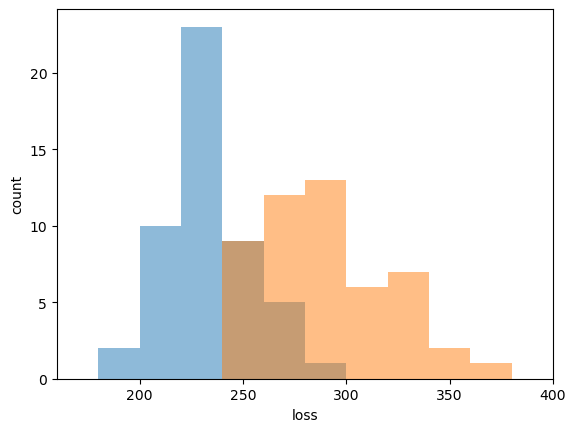

In [45]:
bins = np.arange(160,400,20) # fixed bin size

plt.xlim([160, 400])

plt.hist(loss_list, bins=bins, alpha=0.5)
plt.hist(rand_loss_list, bins=bins, alpha=0.5)



plt.xlabel('loss')
plt.ylabel('count')

plt.show()

In [60]:
i = 6000

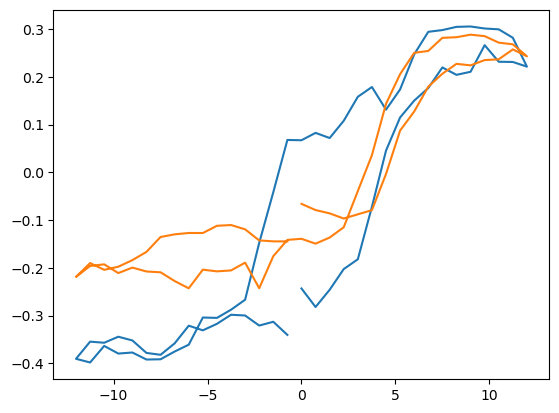

In [61]:
pred_loop = predict(model, np.array(X[i]).reshape([1, 1, image_patch, image_patch])).reshape(64)
plt.plot(spec, pred_loop)
plt.plot(spec, y[i][0])


In [62]:
pred_im = predict(autoencoder, X[i].reshape([1, 1, image_patch, image_patch])).reshape([image_patch, image_patch])

<function matplotlib.pyplot.show(close=None, block=None)>

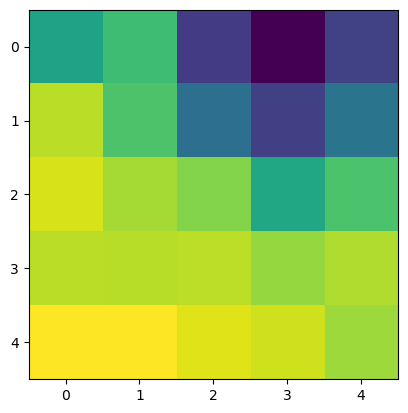

In [63]:
plt.imshow(pred_im)
plt.show

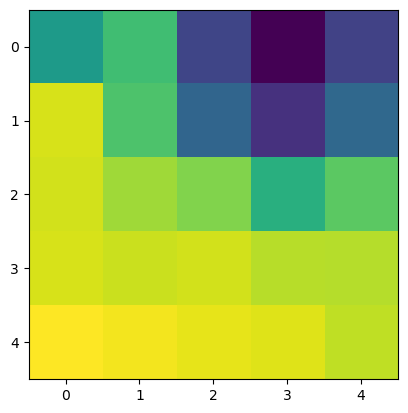

In [64]:
plt.imshow(X[i].reshape([image_patch, image_patch]))